In [1]:
import os
import logging
import pyro
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import seaborn as sns


In [2]:
smoke_test = ('CI' in os.environ)

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
DATA_URL = "./rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [4]:
df

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113
...,...,...,...
229,0,1.677,4860.269
230,0,2.323,787.749
231,1,1.761,9419.122
232,1,0.533,774.010


In [5]:
df = df[np.isfinite(df.rgdppc_2000)]
df


,cont_africa,rugged,rgdppc_2000
2,1,0.858,1794.729
4,0,3.427,3703.113
7,0,0.769,20604.460
8,0,0.775,12173.680
9,0,2.688,2421.985
...,...,...,...
229,0,1.677,4860.269
230,0,2.323,787.749
231,1,1.761,9419.122
232,1,0.533,774.010


In [6]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

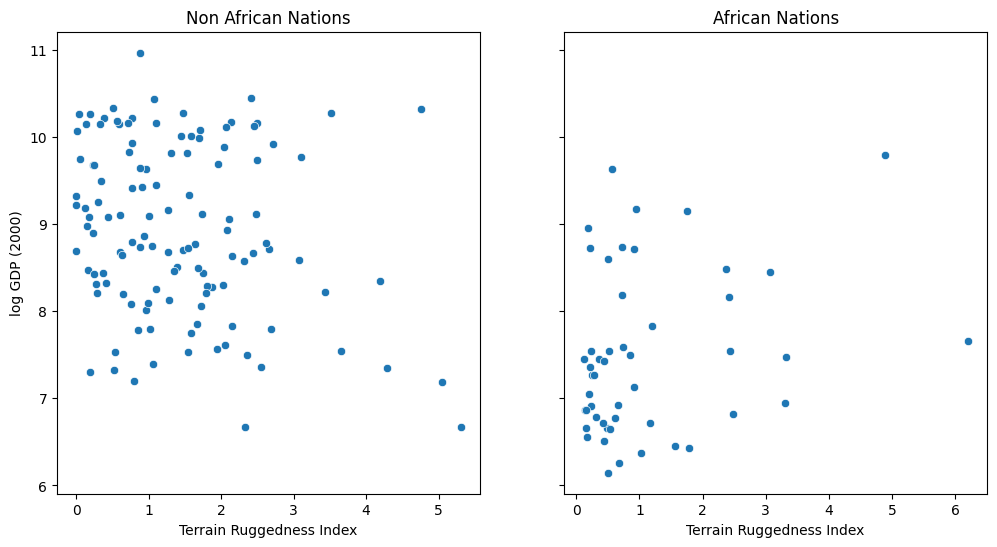

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [8]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [9]:
is_cont_africa

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1.])

In [10]:
ruggedness

tensor([8.5800e-01, 3.4270e+00, 7.6900e-01, 7.7500e-01, 2.6880e+00, 6.0000e-03,
        1.4300e-01, 3.5130e+00, 1.6720e+00, 1.7800e+00, 3.8800e-01, 1.4100e-01,
        2.3600e-01, 1.8600e-01, 1.4790e+00, 2.3100e-01, 5.5000e-02, 2.3110e+00,
        1.6400e-01, 6.0700e-01, 8.5300e-01, 2.4000e-01, 9.6300e-01, 1.8100e-01,
        1.9700e-01, 7.7500e-01, 4.7610e+00, 2.4810e+00, 1.8780e+00, 2.2400e-01,
        5.1500e-01, 4.4300e-01, 1.5200e-01, 8.8500e-01, 3.3280e+00, 2.3670e+00,
        2.1120e+00, 2.7180e+00, 8.8400e-01, 5.9700e-01, 2.4320e+00, 3.0000e-03,
        1.8900e-01, 1.6410e+00, 5.1000e-01, 1.2780e+00, 7.2300e-01, 2.4810e+00,
        1.6890e+00, 1.2300e-01, 1.5700e+00, 3.2800e-01, 1.3960e+00, 1.0980e+00,
        2.1800e-01, 5.6800e-01, 3.6590e+00, 2.2800e-01, 7.4000e-01, 3.5300e-01,
        4.9100e-01, 5.5900e-01, 3.1030e+00, 2.0880e+00, 1.8070e+00, 2.7300e-01,
        2.5010e+00, 2.1500e+00, 1.2670e+00, 2.3620e+00, 3.4600e-01, 9.6700e-01,
        1.0130e+00, 5.1300e-01, 2.4450e+

In [11]:
log_gdp

tensor([ 7.4926,  8.2169,  9.9333,  9.4070,  7.7923,  9.2125, 10.1432, 10.2746,
         7.8520,  6.4324, 10.2148,  6.8661,  6.9062,  7.2992,  8.6960,  9.6758,
         9.7396,  8.5745,  8.4768,  8.6775,  7.7827,  8.8957,  9.6350,  8.9493,
         7.0458, 10.2142, 10.3143,  9.1177,  8.2760,  7.3624,  7.5405,  6.5053,
         6.8642,  8.7393,  7.4789,  8.4886,  9.0620,  9.9193,  9.6404, 10.1457,
         7.5401,  8.6881, 10.2664,  8.7657,  8.5975,  8.1237,  8.1882,  6.8155,
         9.9881,  9.1863,  6.4549, 10.1485,  8.5071, 10.1542,  8.7191, 10.1785,
         7.5393,  7.5458,  7.5887,  7.4548,  6.6625,  9.6284,  9.7638,  8.9275,
         8.2876,  8.3119, 10.1580,  7.8265,  9.1638,  7.4947,  9.4898,  8.0157,
         7.7895, 10.3265,  8.6702, 10.2726, 10.0799, 10.1264,  8.2026,  8.2550,
        10.1743,  8.4326,  6.9263,  7.3524,  7.5278,  9.3259,  9.6911,  9.6778,
         7.3588,  8.3467,  8.6342,  8.1958,  7.6604,  9.0788, 10.9646,  8.9751,
         9.8299,  8.1645,  7.1940,  6.71

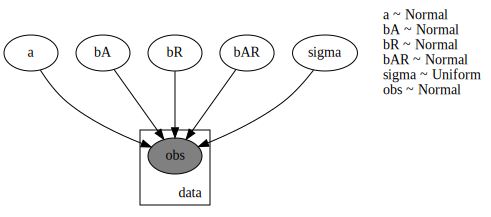

In [12]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)


Elbo loss: 694.9404826164246
Elbo loss: 524.3822077512741
Elbo loss: 475.668145775795
Elbo loss: 399.9908837676048
Elbo loss: 315.23277485370636
Elbo loss: 254.76769989728928
Elbo loss: 248.2370549440384
Elbo loss: 248.4266900420189
Elbo loss: 248.46450012922287
Elbo loss: 257.41463351249695


CPU times: user 4.46 s, sys: 30.7 ms, total: 4.49 s
Wall time: 4.5 s


Text(0, 0.5, 'ELBO loss')

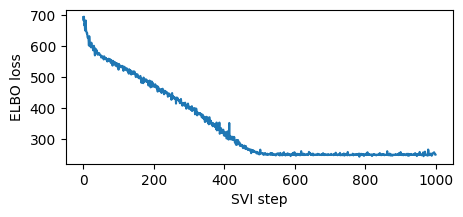

In [13]:

%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [14]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.07036687
AutoNormal.locs.bA -1.8474661
AutoNormal.scales.bA 0.14070092
AutoNormal.locs.bR -0.19032115
AutoNormal.scales.bR 0.044044245
AutoNormal.locs.bAR 0.35599774
AutoNormal.scales.bAR 0.07937442
AutoNormal.locs.sigma -2.2058628
AutoNormal.scales.sigma 0.06052672


In [32]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]


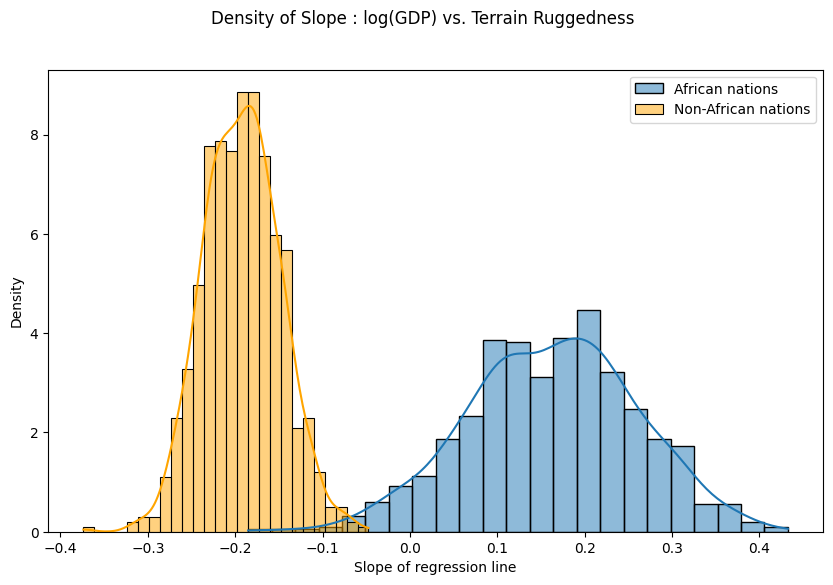

In [16]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [17]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

In [18]:
len(is_cont_africa)

170

In [19]:
len(ruggedness)

170

In [20]:
len(svi_gdp)

800

In [21]:
svi_gdp.shape

torch.Size([800, 170])

In [22]:
svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].shape

torch.Size([170])

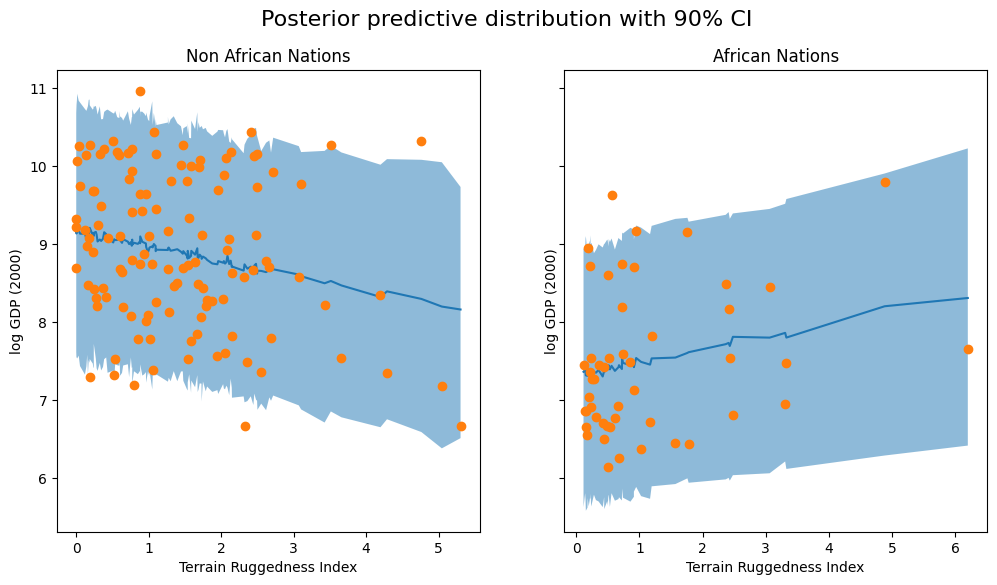

In [23]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [24]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)


In [25]:
mvn_guide

AutoMultivariateNormal()

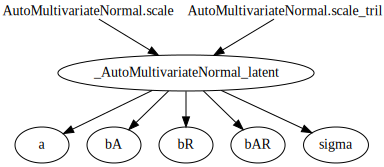

In [26]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)


In [27]:
def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

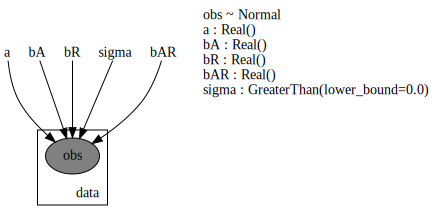

In [28]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)


Elbo loss: 702.4906432628632
Elbo loss: 548.757657289505
Elbo loss: 490.9642730951309
Elbo loss: 401.8140125274658
Elbo loss: 333.77806627750397
Elbo loss: 247.01823371648788
Elbo loss: 248.3894448876381
Elbo loss: 247.35121250152588
Elbo loss: 248.2095891237259
Elbo loss: 247.2100682258606


CPU times: user 3.79 s, sys: 27.1 ms, total: 3.82 s
Wall time: 3.82 s


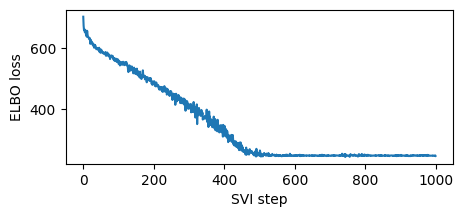

In [29]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

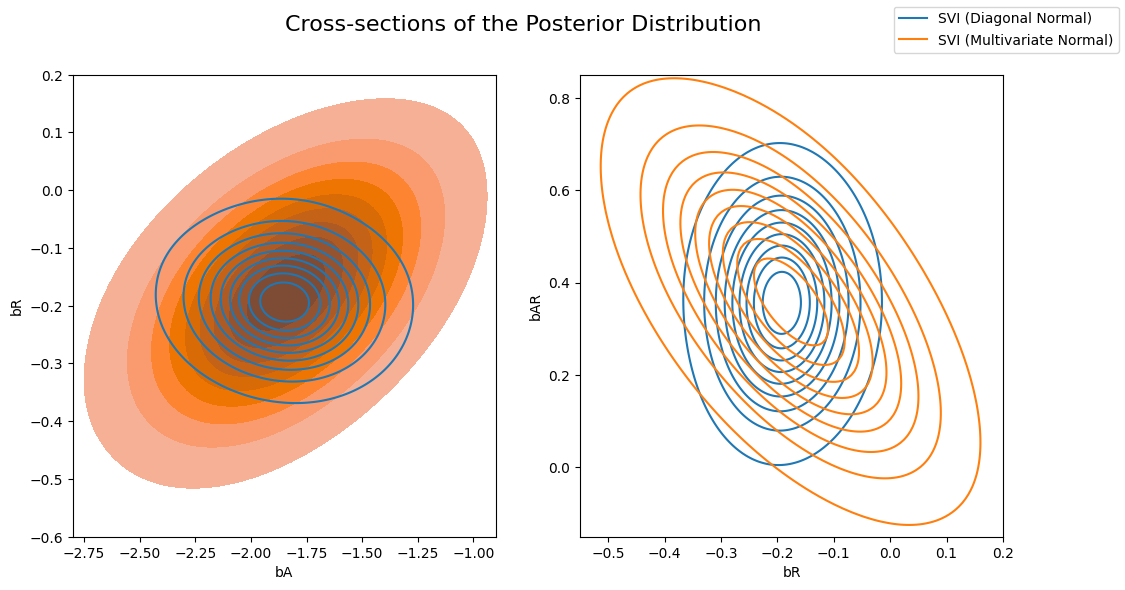

In [31]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

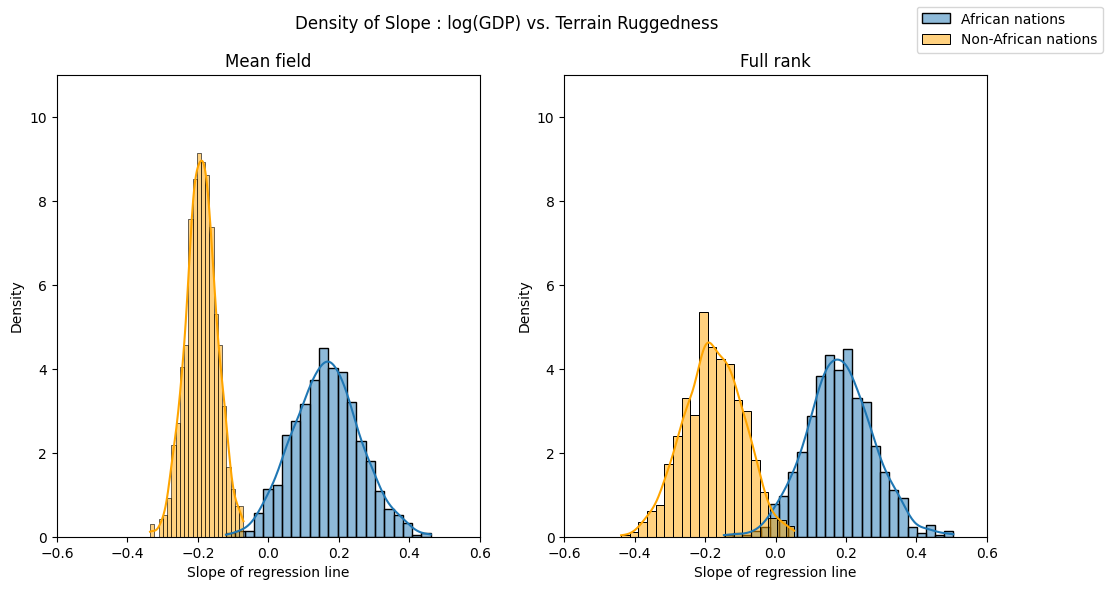

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');


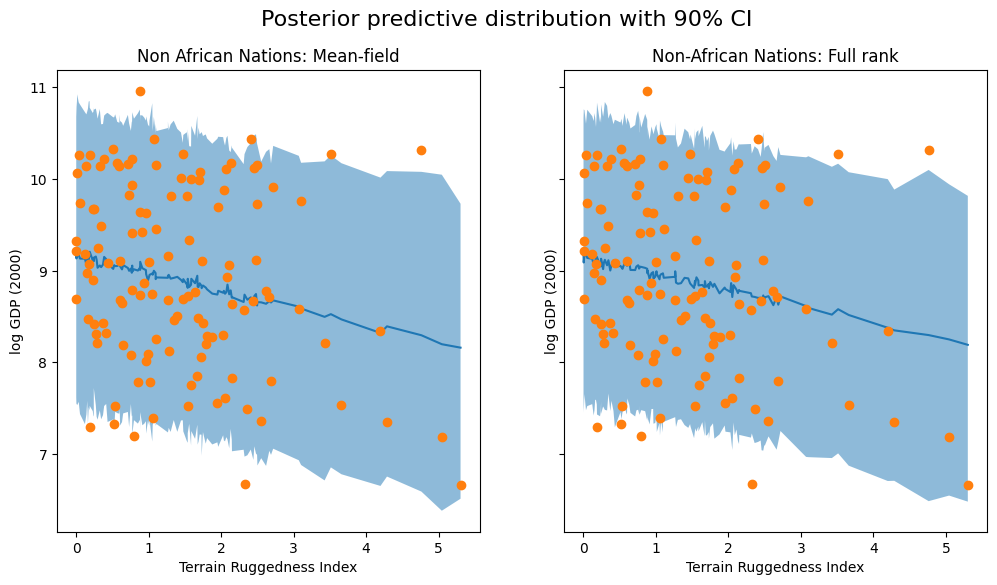

In [34]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");